In [1]:
import nolearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='poster', style='dark')

# file kfkd.py
import os

from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

from __future__ import print_function

In [2]:
FTRAIN = 'training.csv'
FTEST = 'test.csv'

In [3]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


# def plot_training_history(net0, yscale='log'):
#     import matplotlib.pyplot as plt
#     train_loss = np.array([i["train_loss"] for i in net0.train_history_])
#     valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
    
#     fig = plt.figure()
    
#     fig.yscale(yscale)
        
#     fig.plot(train_loss, '-r', label="train",)
#     fig.plot(valid_loss, label="valid")
# #     fig.grid()
# #     plt.legend()
# #     plt.xlabel("epoch")
# #     plt.ylabel("loss")

# #     pyplot.ylim(0.4, 1)
# #     pyplot.xlim(-1, len(net0.train_history_))
#     # pyplot.yscale("log")
#     plt.show()
    
    
def plot_training_history(net0, yscale='log'):
    import matplotlib.pyplot as plt
    train_loss = np.array([i["train_loss"] for i in net0.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
    
    fig = plt.figure()
    
    fig = plt.yscale(yscale)
        
    fig = plt.plot(train_loss, '-r', label="train",)
    fig = plt.plot(valid_loss, label="valid")
    fig = plt.grid()
    fig =  plt.legend()
    fig = plt.xlabel("epoch")
    fig = plt.ylabel("loss")

#     pyplot.ylim(0.4, 1)
#     pyplot.xlim(-1, len(net0.train_history_))
    
    return fig


def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=15, color='magenta')
    
    
def plot_faces(X_test, y_pred):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(X_test[i], y_pred[i], ax)

    plt.show()

In [4]:
X, y = load()

IOError: File training.csv does not exist

In [38]:
np.shape(X)

(2140, 9216)

In [39]:
np.shape(y)

(2140, 30)

In [40]:
# simple ANN with one layer

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net2 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        ,('hidden', layers.DenseLayer)
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=10,  # we want to train this many epochs
    verbose=1,
)

net2.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.14033       0.02833      4.95392  0.34s
      2       0.01926       0.01713      1.12402  0.31s
      3       0.01485       0.01552      0.95721  0.30s
      4       0.01339       0.01416      0.94596  0.30s
      5       0.01248       0.01340      0.93073  0.29s
      6       0.01187       0.01283      0.92483  0.29s
      7       0.01138       0.01235      0.92141  0.29s
      8       0.01098       0.01195      0.91905  0.29s
      9       0.01063       0.01158      0.91784  0.29s
     10       0.01033       0.01126      0.91726  0.28s


/home/aflyax/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f758ef314e0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f758eefbb70>,
     custom_score=None, hidden_num_units=100, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x7f758e44ea60>,
     objective_loss_function=<function squared_error at 0x7f758f05b158>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f75899b4d30>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7f75899b4c18>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit object at 

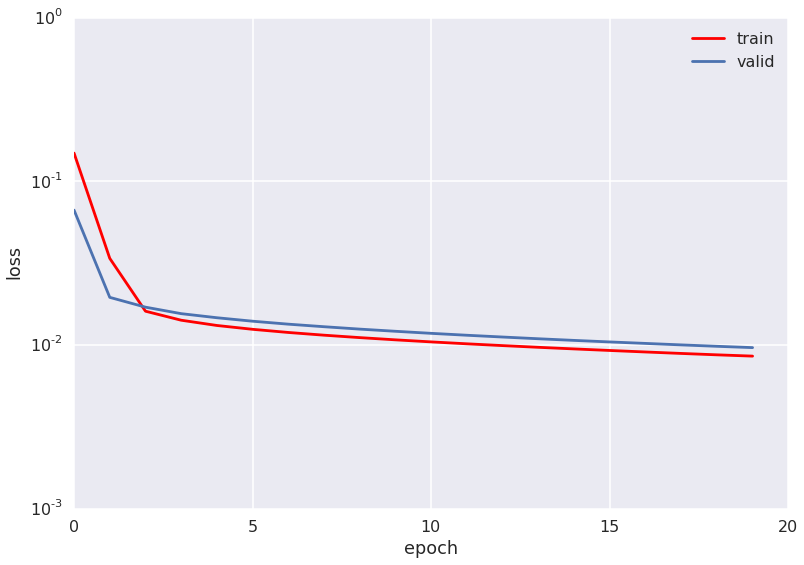

In [41]:
hist_fig = plot_training_history(net1)

/home/aflyax/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


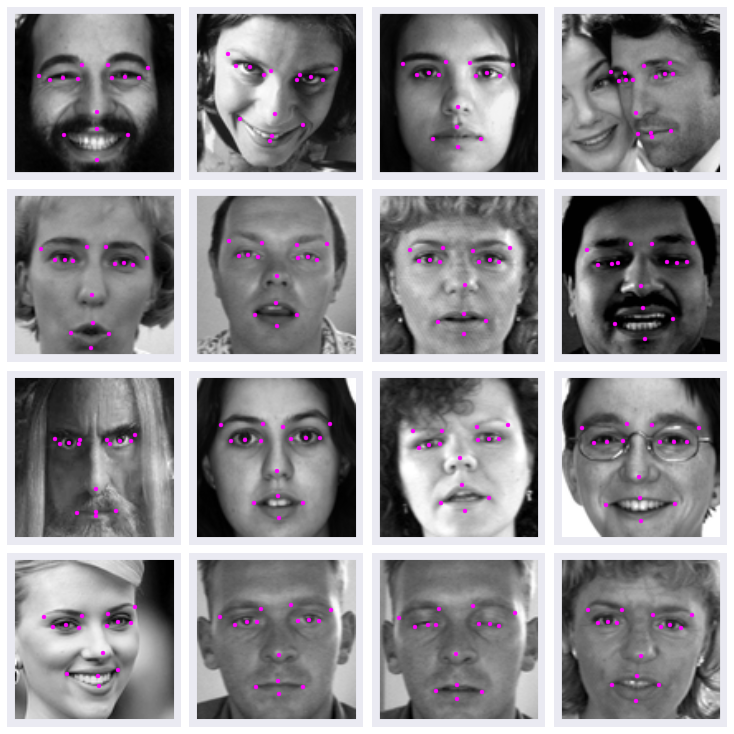

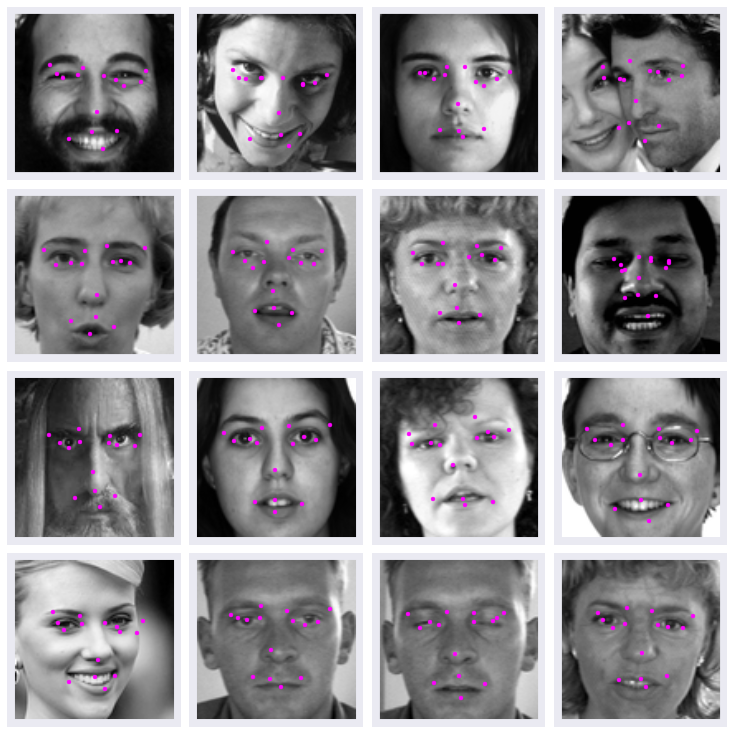

In [42]:
# X_test, _ = load(test=True)
y_pred_1 = net1.predict(X)

# plot_faces(X_test, y_pred_1)
plot_faces(X, y)
plot_faces(X, y_pred_1)

/home/aflyax/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


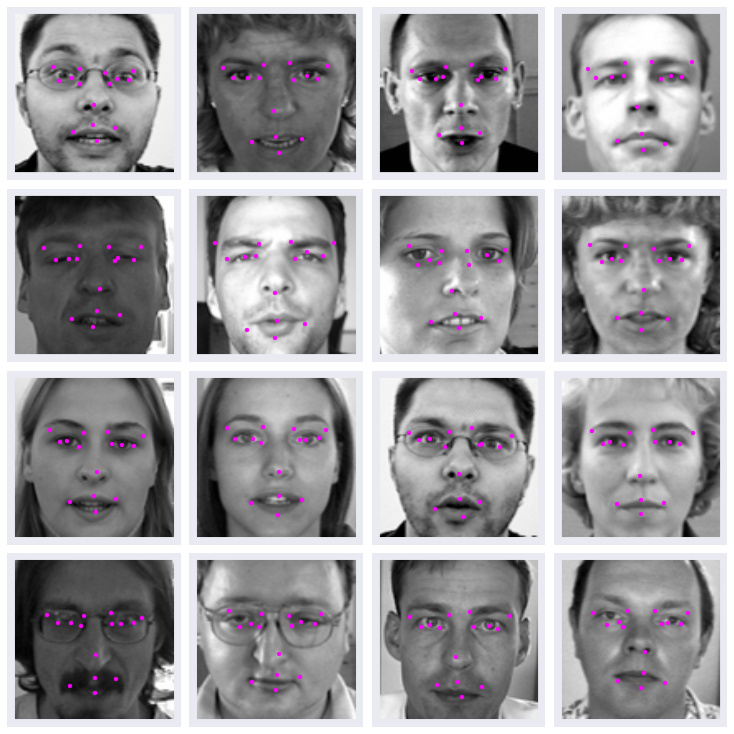

In [25]:
y_pred_2 = net2.predict(X_test)
plot_faces(X_test, y_pred_2)

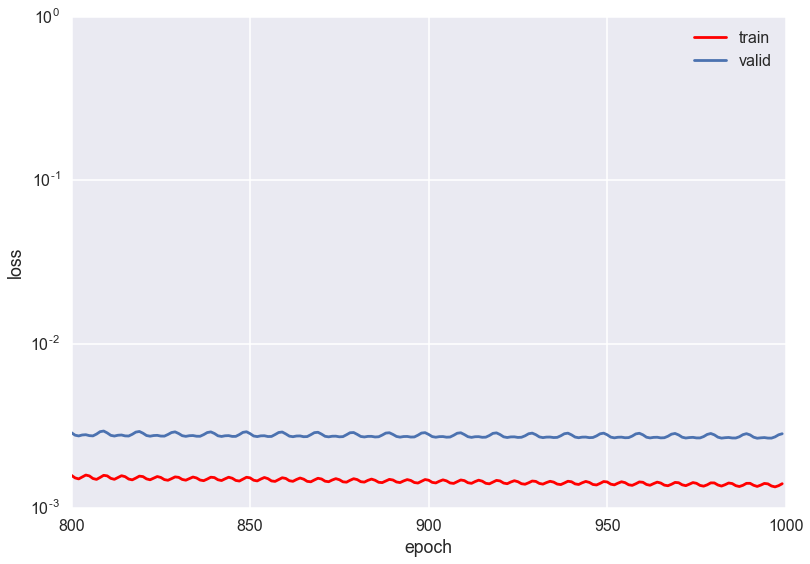

In [28]:
hist_fig = plot_training_history(net1)
hist_fig = plt.xlim(800, 1000)

In [54]:
# simple ANN with two layerz

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net3 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        ,('hidden1', layers.DenseLayer)
        ,('hidden2', layers.DenseLayer)        
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=500,  # number of units in hidden layer
    hidden2_num_units=500,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
)

net3.fit(X, y)

# Neural Network with 4874030 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input      9216
  1  hidden1     500
  2  hidden2     500
  3  output       30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.04255       0.02000      2.12710  5.15s
      2       0.01670       0.01642      1.01716  4.34s
      3       0.01427       0.01481      0.96331  4.61s
      4       0.01292       0.01381      0.93530  4.63s
      5       0.01201       0.01307      0.91951  4.34s
      6       0.01132       0.01241      0.91262  4.34s
      7       0.01075       0.01185      0.90719  4.59s
      8       0.01027       0.01137      0.90297  4.72s
      9       0.00984       0.01096      0.89807  5.28s
     10       0.00946       0.01059      0.89389  4.66s
     11       0.00913       0.01026      0.88927  5.21s
     12       0.00883       0.00997      0.88570  4.85s
     13       0.0

/home/aflyax/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f758ef314e0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f758eefbb70>,
     custom_score=None, hidden1_num_units=500, hidden2_num_units=500,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f758e44ea60>,
     objective_loss_function=<function squared_error at 0x7f758f05b158>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f75794d3278>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7f75794d3390>],
     output_nonlinearity=None, output_num_

In [27]:
import _pickle as pickle
with open('net3.pickle', 'wb') as f:
    pickle.dump(net3, f, -1)

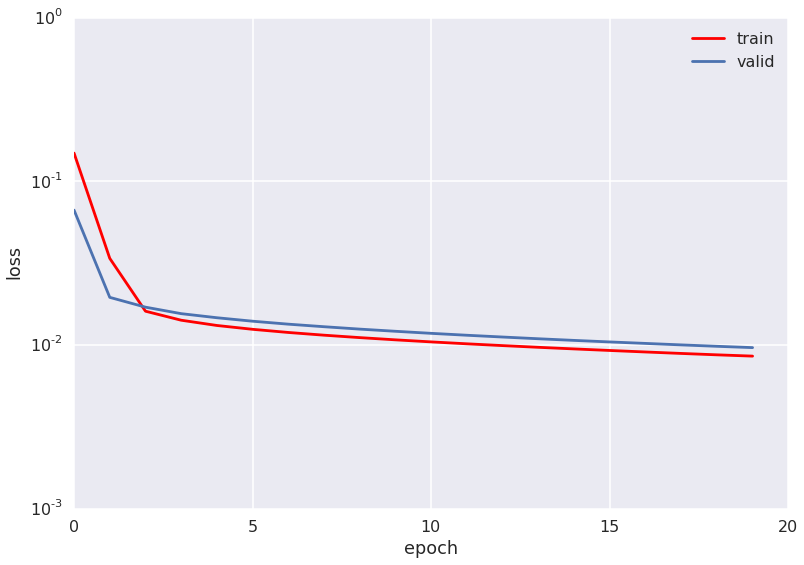

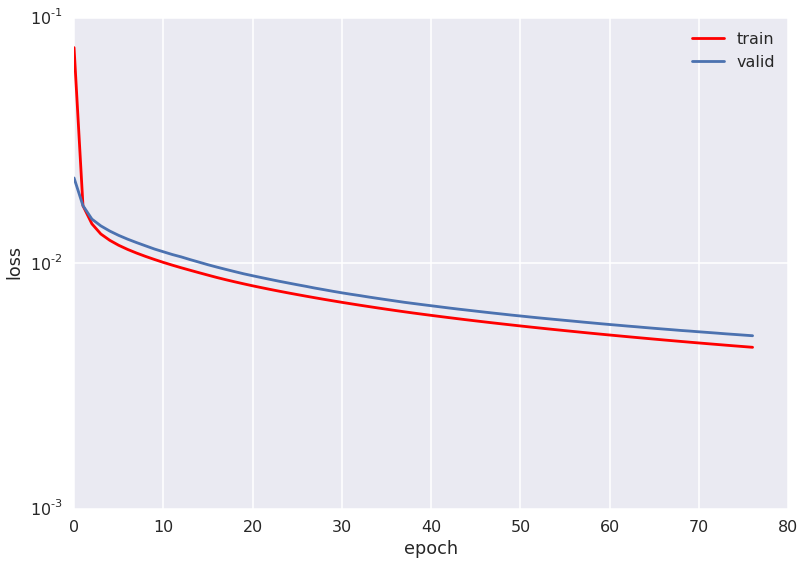

In [28]:
hist_1 = plot_training_history(net1)
hist_3 = plot_training_history(net3)

In [52]:
# simple ANN with two layerz

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net4 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
#         , ('dropoutf', layers.DropoutLayer)
        , ('dense0', layers.DenseLayer)
#         , ('dropout', layers.DropoutLayer)
        , ('dense1', layers.DenseLayer)
#         , ('dropout2', layers.DropoutLayer)
#             ('dense2', layers.DenseLayer),
#             ('dropout3', layers.DropoutLayer), 

        , ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216)  # 96x96 input pixels per batch
    
#     , dropoutf_p=0.1
    , dense0_num_units=100
#     , dropout_p=0.1
    , dense1_num_units=100
#     , dropout2_p=0.1
    
    , output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
)

net4.fit(X, y)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  dense0     100
  2  dense1     100
  3  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.09968       0.08173      1.21966  0.31s
      2       0.08105       0.08012      1.01165  0.33s
      3       0.07992       0.07949      1.00552  0.34s
      4       0.07937       0.07904      1.00408  0.35s
      5       0.07899       0.07869      1.00377  0.37s
      6       0.07868       0.07840      1.00351  0.39s
      7       0.07842       0.07816      1.00340  0.37s
      8       0.07820       0.07793      1.00346  0.38s
      9       0.07801       0.07774      1.00353  0.37s
     10       0.07784       0.07755      1.00365  0.32s
     11       0.07767       0.07738      1.00374  0.32s
     12       0.07751       0.07722      1.00378  0.31s
     13       0.07737   

/home/aflyax/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f758ef314e0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f758eefbb70>,
     custom_score=None, dense0_num_units=100, dense1_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f758e44ea60>,
     objective_loss_function=<function squared_error at 0x7f758f05b158>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f757cecfa90>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7f757cecf828>],
     output_num_units=30, regression=True,
   

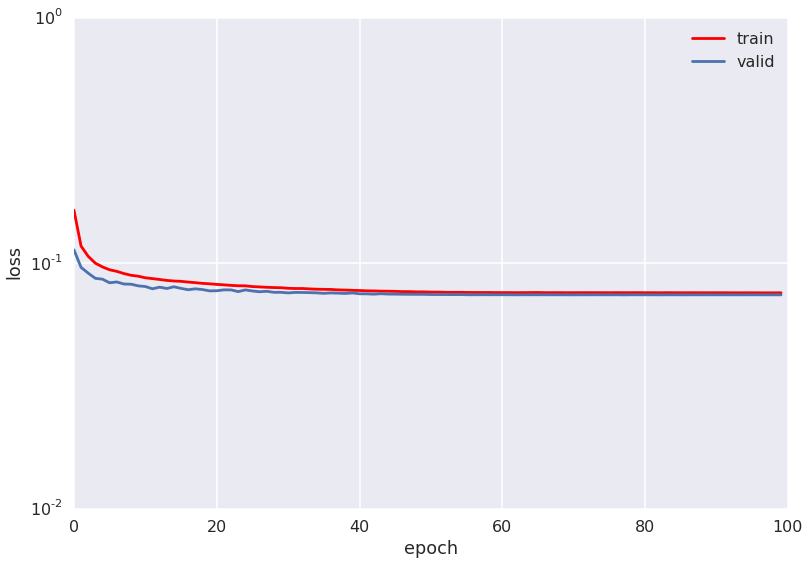

In [45]:
plot_training_history(net4)

ImageId    1783
Image      1783
dtype: int64


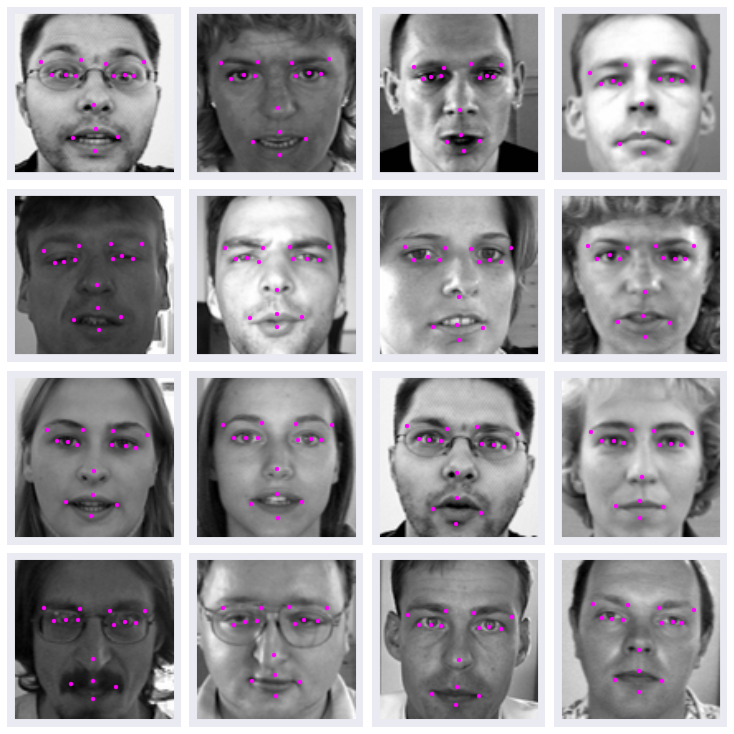

In [71]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=15, color='magenta')
    


